In [16]:
import pandas as pd
from tqdm.autonotebook  import tqdm

/var/folders/5w/z16gwdx123l_m1mtmtq2mn380000gp/T/ipykernel_67825/1064037480.py:2: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook  import tqdm


In [17]:
# read data and preprocess the column names into ["id", "time", "Y_obs"]
dta = pd.read_csv("../smoking_data.csv")
dta = dta[["state", "year", "cigsale"]]
dta.columns = ["id", "time", "Y_obs"]


In [3]:
dta

,id,time,Y_obs
0,1,1970,89.800003
1,1,1971,95.400002
2,1,1972,101.099998
3,1,1973,102.900002
4,1,1974,108.199997
...,...,...,...
1204,39,1996,110.300003
1205,39,1997,108.800003
1206,39,1998,102.900002
1207,39,1999,104.800003


In [4]:
import matplotlib.pyplot as plt

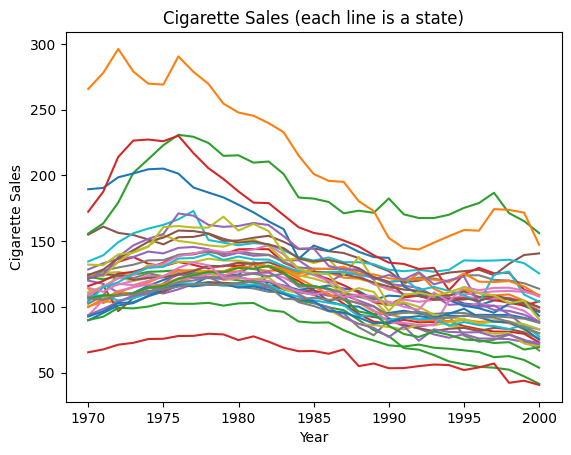

In [5]:
# group by id and plot the time series
for id in dta['id'].unique():
    plt.plot(dta[dta['id'] == id]['time'], dta[dta['id'] == id]['Y_obs'], label=id)
# plt.legend()
plt.xlabel('Year')
plt.ylabel('Cigarette Sales')
plt.title('Cigarette Sales (each line is a state)')
plt.show()

In [19]:
# from tabpfn_extensions.hpo import (
#     TunedTabPFNClassifier,
#     TunedTabPFNRegressor,
# )
from tabpfn.constants import ModelVersion

In [ ]:
import numpy as np
from tabpfn.regressor import TabPFNRegressor  # pip install tabpfn

# build the dict once (robust to dtype)
dta_dict = {(int(row['id']), int(row['time'])): float(row['Y_obs']) for _, row in dta.iterrows()}

import copy
y_test = copy.deepcopy(dta_dict)  # will hold recursive preds

# basic metadata
state_ids = sorted(int(s) for s in dta['id'].unique())
treated_id = 3   # California
pre_start, pre_end   = 1970, 1983   # train on pre
post_start, post_end = 1984, 2000   # predict on post
w = 5  # past lags of the target
r = 5  # future lookahead for controls

for i in tqdm(state_ids):
    if i == treated_id:
        continue  # skip CA here (this loop is for placebos)

    # --------- build train set ----------
    X_train, y_train = [], []
    for year in range(pre_start, pre_end + 1):
        y_train.append(dta_dict[(i, year)])
        feat = []

        for j in state_ids:
            if j in (treated_id, i):
                continue
            for y in range(year - w, year + r + 1):
                feat.append(dta_dict.get((j, y), np.nan))
            # feat.append(dta_dict.get((j, year), np.nan)) # contemporary

        for y in range(year - w, year):
            feat.append(dta_dict.get((i, y), np.nan))

        X_train.append(feat)

    X_train = np.asarray(X_train, dtype=float)
    y_train = np.asarray(y_train, dtype=float)


    # model = TunedTabPFNRegressor()
    model = TabPFNRegressor.create_default_for_version(ModelVersion.V2)
    model.fit(X_train, y_train)

    # --------- recursive post-period prediction ----------
    for year in range(post_start, post_end + 1):
        feat = []

        for j in state_ids:
            if j in (treated_id, i):
                continue
            for y in range(year - w, year + r + 1):
                feat.append(dta_dict.get((j, y), np.nan))
            # feat.append(dta_dict.get((j, year), np.nan)) # contemporary

        for y in range(year - w, year):
            feat.append(y_test.get((i, y), np.nan))
        # print(len(feat))
        yhat = float(model.predict(np.asarray([feat], dtype=float))[0])
        y_test[(i, year)] = yhat


100%|██████████| 39/39 [02:10<00:00,  3.34s/it]


In [54]:
import pandas as pd
import numpy as np

pred_df = pd.DataFrame(
    [(i, yr, val) for (i, yr), val in y_test.items() if i!=3],
    columns=["id", "year", "predicted"]
)

obs_df = pd.DataFrame(
    [(i, yr, val) for (i, yr), val in dta_dict.items() if i!=3],
    columns=["id", "year", "obs"]
)

out = obs_df.merge(pred_df, on=["id", "year"], how="left")
out["gap"] = out["obs"] - out["predicted"]

out = out.sort_values(["id", "year"]).reset_index(drop=True)

out = out[["id", "year", "predicted", "obs", "gap"]]


In [55]:
out[out['year'] == 1989]

,id,year,predicted,obs,gap
19,1,1989,81.181892,105.599998,24.418106
50,2,1989,112.312042,118.300003,5.987961
81,4,1989,129.884857,88.800003,-41.084854
112,5,1989,111.937943,100.599998,-11.337944
143,6,1989,153.988770,131.699997,-22.288773
174,7,1989,113.631111,117.099998,3.468887
205,8,1989,107.074623,78.400002,-28.674622
236,9,1989,124.791008,104.599998,-20.191010
267,10,1989,144.578644,132.500000,-12.078644
298,11,1989,111.128052,94.400002,-16.728050


In [60]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(out[out['year'] == 1989]['obs'], out[out['year'] == 1989]['predicted'])

In [61]:
mse

495.5874830771264

In [ ]:
# out.to_csv('tabpfn_predictions_synbeats_5year_hpo.csv')

# Salil 

## trial

In [ ]:
import os
import sys
import argparse
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.decomposition import PCA
from tabpfn.regressor import TabPFNRegressor
from tabpfn.constants import ModelVersion

In [ ]:
def build_synbeats_style_features(dta, exclude_states=None, n_pcs=2):
    """
    Build enhanced features in synbeats style.

    Parameters:
    -----------
    dta : pd.DataFrame
        DataFrame with columns ['id', 'time', 'Y_obs']
    exclude_states : list or None
        List of state IDs to exclude from panel statistics and PCA
    n_pcs : int
        Number of PCA components (default: 2)

    Returns:
    --------
    feature_df : pd.DataFrame
        DataFrame with computed features
    feature_cols : list
        List of feature column names
    """
    if exclude_states is None:
        exclude_states = []

    df = dta.copy().sort_values(['id', 'time'])

    # Filter out excluded states for panel computations
    df_for_panel = df[~df['id'].isin(exclude_states)].copy()

    # ---------- 1. Time index ----------
    t0 = df['time'].min()
    df['t'] = df['time'] - t0
    df['t2'] = df['t'] ** 2

    # ---------- 2. Horizontal (within-state) features ----------
    g = df.groupby('id')

    df['lag1'] = g['Y_obs'].shift(1)
    df['lag2'] = g['Y_obs'].shift(2)
    df['lag3'] = g['Y_obs'].shift(3)

    # difference of lags (uses only past info)
    df['diff_lag'] = df['lag1'] - df['lag2']

    # mean of last 3 observations (t-1, t-2, t-3)
    df['mean_lag3'] = (df['lag1'] + df['lag2'] + df['lag3']) / 3.0

    # ---------- 3. Vertical (panel) features ----------
    # Panel stats per year (across control states only)
    time_stats = (
        df_for_panel.groupby('time')['Y_obs']
          .agg(panel_mean='mean', panel_sd='std')
          .reset_index()
    )
    df = df.merge(time_stats, on='time', how='left')

    # ---------- 4. PCA factors across states per year ----------
    # Pivot to (time x state) matrix, excluding treated states
    panel_wide = df_for_panel.pivot(index='time', columns='id', values='Y_obs').sort_index()

    # Simple interpolation for missing values
    panel_wide_interp = panel_wide.interpolate(limit_direction='both', axis=0)

    if len(panel_wide_interp.columns) >= n_pcs and len(panel_wide_interp) >= n_pcs:
        pca = PCA(n_components=n_pcs)
        pcs = pca.fit_transform(panel_wide_interp.values)
        pc_cols = [f'pc{k+1}' for k in range(n_pcs)]
        pc_df = (
            pd.DataFrame(pcs, index=panel_wide_interp.index, columns=pc_cols)
              .reset_index()
              .rename(columns={'index': 'time'})
        )
    else:
        # If not enough states/observations for PCA, create dummy columns
        pc_cols = [f'pc{k+1}' for k in range(n_pcs)]
        pc_df = pd.DataFrame({
            'time': df['time'].unique(),
            **{col: 0.0 for col in pc_cols}
        })

    df = df.merge(pc_df, on='time', how='left')

    # ---------- 5. State-specific linear trend & residual ----------
    trends = []
    for sid, g_state in df.groupby('id'):
        # need at least 2 points to fit a line
        valid_data = g_state[['t', 'Y_obs']].dropna()
        if len(valid_data) >= 2:
            slope, intercept = np.polyfit(valid_data['t'], valid_data['Y_obs'], 1)
        else:
            slope, intercept = np.nan, np.nan
        trends.append({'id': sid, 'trend_slope': slope, 'trend_intercept': intercept})

    trends = pd.DataFrame(trends)
    df = df.merge(trends, on='id', how='left')

    df['trend_pred'] = df['trend_intercept'] + df['trend_slope'] * df['t']
    df['residual'] = df['Y_obs'] - df['trend_pred']
    df['lag1_resid'] = df.groupby('id')['residual'].shift(1)

    # ---------- 6. Assemble final feature matrix ----------
    feature_cols = [
        'id',
        't', 't2',
        'lag1', 'lag2', 'lag3',
        'diff_lag', 'mean_lag3',
        'panel_mean', 'panel_sd',
    ] + pc_cols + [
        'trend_pred', 'lag1_resid'
    ]

    feature_df = df[['time', 'Y_obs'] + feature_cols].copy()

    return feature_df, feature_cols

In [ ]:
def run_tabpfn_predictions_synbeats(dta, treated_id=3, n_pcs=2):
    """
    Run TabPFNv2 predictions using synbeats-style features.

    This version uses the synbeats features for the target state only,
    combined with raw values from control states in windows (similar to basic approach).

    Parameters:
    -----------
    dta : pd.DataFrame
        Input data with columns ['id', 'time', 'Y_obs']
    treated_id : int
        ID of the treated state to exclude (default: 3 for California)
    n_pcs : int
        Number of PCA components

    Returns:
    --------
    dict
        Dictionary mapping (state_id, year) to predicted values
    """
    # Basic metadata
    state_ids = sorted(int(s) for s in dta['id'].unique())
    pre_start, pre_end = 1970, 1983
    post_start, post_end = 1984, 2000
    w = 5  # window for training data
    r = 5  # future lookahead

    print(f"\nTraining on years {pre_start}-{pre_end}")
    print(f"Predicting years {post_start}-{post_end}")
    print(f"Number of states: {len(state_ids)}")
    print(f"Excluding treated state (id={treated_id})")
    print(f"Using synbeats-style features with {n_pcs} PCA components\n")

    # Dictionary to store predictions
    predictions_dict = {}

    # Original data dictionary for comparison
    dta_dict = {(int(row['id']), int(row['time'])): float(row['Y_obs'])
                for _, row in dta.iterrows()}

    for target_state in tqdm(state_ids, desc="Processing states"):
        if target_state == treated_id:
            continue  # skip treated state

        # Build features excluding both California and current target state
        exclude_list = [treated_id, target_state]
        feature_df, feature_cols = build_synbeats_style_features(
            dta,
            exclude_states=exclude_list,
            n_pcs=n_pcs
        )

        # --------- Build train set ----------
        X_train, y_train = [], []

        for year in range(pre_start, pre_end + 1):
            # Get target state's synbeats features for this year
            target_row = feature_df[
                (feature_df['id'] == target_state) &
                (feature_df['time'] == year)
            ]

            if len(target_row) == 0 or target_row[feature_cols].isna().any().any():
                continue

            y_train.append(float(target_row['Y_obs'].iloc[0]))

            # Use synbeats features for target state
            target_features = target_row[feature_cols].values.flatten()

            # Add raw values from control states in window [year-w, year+r]
            control_raw = []
            for j in state_ids:
                if j in exclude_list:
                    continue
                for y in range(year - w, year + r + 1):
                    control_raw.append(dta_dict.get((j, y), np.nan))

            # Combine: synbeats features + control state raw values
            feat = np.concatenate([target_features, control_raw])
            X_train.append(feat)

        if len(X_train) == 0:
            print(f"Warning: No training data for state {target_state}, skipping")
            continue

        X_train = np.asarray(X_train, dtype=float)
        y_train = np.asarray(y_train, dtype=float)

        # Fit TabPFNv2 model
        model = TabPFNRegressor.create_default_for_version(ModelVersion.V2)
        model.fit(X_train, y_train)

        # --------- Predict post-period ----------
        for year in range(post_start, post_end + 1):
            # Get target state's synbeats features for prediction year
            target_row = feature_df[
                (feature_df['id'] == target_state) &
                (feature_df['time'] == year)
            ]

            if len(target_row) == 0:
                continue

            target_features = target_row[feature_cols].values.flatten()

            # Add raw values from control states in window
            control_raw = []
            for j in state_ids:
                if j in exclude_list:
                    continue
                for y in range(year - w, year + r + 1):
                    control_raw.append(dta_dict.get((j, y), np.nan))

            feat = np.concatenate([target_features, control_raw])

            # Ensure feature dimension matches training
            if len(feat) != X_train.shape[1]:
                print(f"Warning: Feature dimension mismatch for state {target_state}, year {year}")
                print(f"Expected {X_train.shape[1]}, got {len(feat)}")
                continue

            yhat = float(model.predict(np.asarray([feat], dtype=float))[0])
            predictions_dict[(target_state, year)] = yhat

    return predictions_dict, dta_dict

In [39]:
feature_df, feature_cols = build_synbeats_style_features(dta)

# X / y for TabPFN
X = feature_df[feature_cols].values
y = feature_df['Y_obs'].values


In [31]:
y

array([102.90000153, 108.19999695, 111.69999695, ..., 102.90000153,
       104.80000305,  90.5       ], shape=(1092,))

Then you can:
restrict feature_df to pre-treatment rows for training,
build prediction rows for California post-1988 by recomputing the same features (using only control states’ Y_obs and California’s pre-period lags), and
call TabPFN’s fit / predict.

In [45]:
year = 1984

test = feature_df[(feature_df['id'] != 3) & (feature_df['id'] != 1)] # california
test = test[(test['time'] >= year - 5) & (test['time'] <= year + 5)]

# for id == 1, only include rows where time < year
temp = feature_df[feature_df['id'] == 1]
temp = temp[temp['time'] < year]

together = pd.concat([test, temp])

X = together[feature_cols].values
y = together['Y_obs'].values



In [46]:
model = TabPFNRegressor.create_default_for_version(ModelVersion.V2)
model.fit(X, y)

yhat = model.predict(X)

mse = mean_squared_error(y, yhat)
mse

7.984392680141316

In [64]:
# Build TabPFN train/predict sets from feature_df using the same (year - w ... year + r) windowing
w, r = 5, 5  # keep consistent with the earlier TabPFN run
treated_id = 3
pre_start, pre_end = 1970, 1983
post_years = [1989]

state_ids = sorted(int(s) for s in feature_df['id'].unique())

# Base values come from feature_df (with raw data as fallback for any dropped rows)
value_lookup = {(int(r.id), int(r.time)): float(r.Y_obs) for r in feature_df[['id', 'time', 'Y_obs']].drop_duplicates().itertuples(index=False)}
value_lookup.update({(int(row['id']), int(row['time'])): float(row['Y_obs']) for _, row in dta.iterrows()})

window_test = value_lookup.copy()  # allow recursive lags for the target unit
window_preds = {}

for i in state_ids:
    if i == treated_id:
        continue

    X_train, y_train = [], []
    for year in range(pre_start, pre_end + 1):
        y_train.append(value_lookup[(i, year)])
        feat = []

        for j in state_ids:
            if j in (treated_id, i):
                continue
            for y in range(year - w, year + r + 1):
                feat.append(value_lookup.get((j, y), np.nan))

        for y in range(year - w, year):
            feat.append(value_lookup.get((i, y), np.nan))

        X_train.append(feat)

    model = TabPFNRegressor.create_default_for_version(ModelVersion.V2)
    model.fit(np.asarray(X_train, dtype=float), np.asarray(y_train, dtype=float))

    for year in post_years:
        feat = []

        for j in state_ids:
            if j in (treated_id, i):
                continue
            for y in range(year - w, year + r + 1):
                feat.append(value_lookup.get((j, y), np.nan))

        for y in range(year - w, year):
            feat.append(window_test.get((i, y), np.nan))

        pred = float(model.predict(np.asarray([feat], dtype=float))[0])
        window_test[(i, year)] = pred
        window_preds[(i, year)] = pred

window_pred_df = pd.DataFrame(
    [(sid, yr, pred) for (sid, yr), pred in window_preds.items()],
    columns=['id', 'year', 'predicted_window']
).sort_values(['id', 'year']).reset_index(drop=True)

window_out = (
    obs_df.merge(window_pred_df, on=['id', 'year'], how='left')
          .query('year in @post_years')
          .sort_values(['id', 'year'])
          .reset_index(drop=True)
)
window_out


,id,year,obs,predicted_window
0,1,1989,105.599998,81.181892
1,2,1989,118.300003,112.312042
2,4,1989,88.800003,129.884857
3,5,1989,100.599998,111.937943
4,6,1989,131.699997,153.988770
5,7,1989,117.099998,113.631111
6,8,1989,78.400002,107.074623
7,9,1989,104.599998,124.791008
8,10,1989,132.500000,144.578644
9,11,1989,94.400002,111.128052


## analyze csvs

In [30]:
import pandas as pd
from sklearn.metrics import mean_squared_error

In [31]:
df1 = pd.read_csv('tabpfn_predictions_cpu_20251118_151706.csv')
df2 = pd.read_csv('tabpfn_predictions_synbeats_gpu_20251119_132345.csv')
df3 = pd.read_csv('chronos2_predictions_variant_b.csv')

In [36]:
year = 1989

In [37]:
temp1 = df1[df1['year'] == year]
mse = mean_squared_error(temp1['obs'], temp1['predicted'])
mse

497.8241129761325

In [38]:
temp2 = df2[df2['year'] == year]
mse = mean_squared_error(temp2['obs'], temp2['predicted'])
mse

505.4256592511626

In [39]:
temp3 = df3[df3['year'] == year]
mse = mean_squared_error(temp3['obs'], temp3['predicted'])
mse


232.4319995339478

In [5]:
temp1.head()

,id,year,predicted,obs,gap
14,1,1984,109.876831,113.000000,3.123169
45,2,1984,125.698814,123.099998,-2.598816
76,4,1984,126.118568,119.699997,-6.418571
107,5,1984,114.137001,112.500000,-1.637001
138,6,1984,151.989212,144.000000,-7.989212


In [6]:
temp2.head()

,id,year,predicted,obs,gap
14,1,1984,111.430153,113.000000,1.569847
45,2,1984,125.857819,123.099998,-2.757820
76,4,1984,125.709099,119.699997,-6.009102
107,5,1984,114.090408,112.500000,-1.590408
138,6,1984,152.044418,144.000000,-8.044418


In [12]:
temp3.head()

,id,year,predicted,obs,gap
14,1,1984,110.478050,113.000000,2.521950
45,2,1984,126.075027,123.099998,-2.975029
76,4,1984,122.893066,119.699997,-3.193069
107,5,1984,113.778542,112.500000,-1.278542
138,6,1984,150.262009,144.000000,-6.262009


## chronos-2

In [22]:
def prepare_chronos_data_variant_b(dta, state_id, treated_id,
                                   pre_start, pre_end, post_start, post_end):
    """
    Variant B: With panel covariates (recommended).
    Uses panel statistics as covariates.

    Parameters:
    -----------
    dta : pd.DataFrame
        Full dataset
    state_id : int
        State to prepare data for
    treated_id : int
        Treated state to exclude
    pre_start, pre_end : int
        Training period boundaries
    post_start, post_end : int
        Prediction period boundaries

    Returns:
    --------
    dict
        Input dictionary for Chronos-2 with covariates
    """
    # Get state's own data
    state_data = dta[dta['id'] == state_id].sort_values('time')
    train_data = state_data[(state_data['time'] >= pre_start) &
                            (state_data['time'] <= pre_end)]

    # Compute panel statistics excluding both treated and target state
    exclude_list = [treated_id, state_id]
    panel_stats = compute_panel_statistics(dta, exclude_list)

    # Get training period panel stats
    train_panel = panel_stats[(panel_stats['time'] >= pre_start) &
                              (panel_stats['time'] <= pre_end)]

    # Get prediction period panel stats (known from other states)
    future_panel = panel_stats[(panel_stats['time'] >= post_start) &
                               (panel_stats['time'] <= post_end)]

    # Time features
    t0 = pre_start
    train_times = train_data['time'].values
    future_times = np.arange(post_start, post_end + 1)

    train_t = train_times - t0
    train_t2 = train_t ** 2
    future_t = future_times - t0
    future_t2 = future_t ** 2

    return {
        "target": train_data['Y_obs'].values,
        "past_covariates": {
            "panel_mean": train_panel['panel_mean'].values,
            "panel_sd": train_panel['panel_sd'].values,
            "time_index": train_t.astype(float),
            "time_index_sq": train_t2.astype(float),
        },
        "future_covariates": {
            "panel_mean": future_panel['panel_mean'].values,
            "panel_sd": future_panel['panel_sd'].values,
            "time_index": future_t.astype(float),
            "time_index_sq": future_t2.astype(float),
        }
    }

In [49]:
def compute_panel_statistics(dta, exclude_states):
    """
    Compute panel-level statistics (mean, std) excluding specified states.

    Parameters:
    -----------
    dta : pd.DataFrame
        Input data with columns ['id', 'time', 'Y_obs']
    exclude_states : list
        List of state IDs to exclude

    Returns:
    --------
    pd.DataFrame
        DataFrame with panel statistics per time period
    """
    panel_data = dta[~dta['id'].isin(exclude_states)]
    stats = panel_data.groupby('time')['Y_obs'].agg([
        ('panel_mean', 'mean'),
        ('panel_sd', 'std'),
        ('panel_median', 'median'),
        ('panel_q25', lambda x: x.quantile(0.25)),
        ('panel_q75', lambda x: x.quantile(0.75)),
        ('panel_q10', lambda x: x.quantile(0.1)),
        ('panel_q90', lambda x: x.quantile(0.9)),
        ('panel_skewness', lambda x: x.skew()),
        ('panel_kurtosis', lambda x: x.kurtosis()),
    ]).reset_index()
    return stats

In [26]:



# # Load data
# print(f"\nLoading data from: {args.data_path}")
# dta = load_smoking_data(args.data_path)
# print(f"Loaded {len(dta)} observations")

# Original data dict for comparison
dta_dict = {(int(row['id']), int(row['time'])): float(row['Y_obs'])
            for _, row in dta.iterrows()}


In [27]:
import numpy as np

In [28]:
state_ids = sorted(int(s) for s in dta['id'].unique())
pre_start, pre_end = 1970, 1983
post_start, post_end = 1984, 2000
prediction_length = post_end - post_start + 1

print("\n=== VARIANT B: With Panel Covariates ===")
print(f"Training on years {pre_start}-{pre_end}")
print(f"Predicting years {post_start}-{post_end}")

predictions_dict = {}

treated_id = 3

for state_id in tqdm(state_ids, desc="Variant B"):
    if state_id == treated_id:
        continue
    
    # Prepare input with covariates
    input_dict = prepare_chronos_data_variant_b(
        dta, state_id, treated_id,
        pre_start, pre_end, post_start, post_end
    )

    # # Make predictions
    # quantiles, mean = pipeline.predict_quantiles(
    #     [input_dict],
    #     prediction_length=prediction_length,
    #     quantile_levels=[0.1, 0.5, 0.9]
    # )

    # # Extract median predictions
    # preds = mean[0].cpu().numpy().flatten()

    # # Store predictions
    # for i, year in enumerate(range(post_start, post_end + 1)):
    #     predictions_dict[(state_id, year)] = float(preds[i])


=== VARIANT B: With Panel Covariates ===
Training on years 1970-1983
Predicting years 1984-2000


Variant B: 100%|██████████| 39/39 [00:00<00:00, 811.31it/s]


In [29]:
input_dict

{'target': array([132.19999695, 131.69999695, 140.        , 141.19999695,
        145.80000305, 160.69999695, 161.5       , 160.3999939 ,
        160.30000305, 168.6000061 , 158.1000061 , 163.1000061 ,
        157.69999695, 141.19999695]),
 'past_covariates': {'panel_mean': array([119.75675799, 123.65135152, 128.88648719, 131.27837825,
         134.36756711, 136.28918931, 140.71351335, 140.56756654,
         139.93783776, 137.26216229, 137.54864852, 137.30810753,
         135.71621601, 130.98108199]),
  'panel_sd': array([33.92402192, 35.55953292, 39.41565101, 39.06488272, 37.92457368,
         37.91615613, 39.93876623, 37.17999662, 34.16921425, 31.60270201,
         30.27391355, 28.96093442, 29.03373167, 27.7697058 ]),
  'time_index': array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
         13.]),
  'time_index_sq': array([  0.,   1.,   4.,   9.,  16.,  25.,  36.,  49.,  64.,  81., 100.,
         121., 144., 169.])},
 'future_covariates': {'panel_mean': array([

In [53]:
def build_tabpfn_design_matrix_variant_b(dta, state_id, treated_id,
                                         pre_start=1970, pre_end=1983):

    # 1. Extract this state’s target series
    state_data = dta[dta['id'] == state_id].sort_values('time')
    train_data = state_data[(state_data['time'] >= pre_start) &
                            (state_data['time'] <= pre_end)]

    y = train_data['Y_obs'].values.astype(float)   # labels

    # 2. Compute panel statistics excluding (treated, this state)
    panel_stats = compute_panel_statistics(
        dta,
        exclude_states=[treated_id, state_id]
    )

    train_panel = panel_stats[(panel_stats['time'] >= pre_start) &
                              (panel_stats['time'] <= pre_end)]

    # 3. Create time features exactly as Chronos does
    t0 = pre_start
    train_times = train_data['time'].values
    train_t = (train_times - t0).astype(float)
    train_t2 = train_t ** 2

    # 4. Build the design matrix X
    X = np.column_stack([
        train_panel['panel_mean'].values.astype(float),
        train_panel['panel_sd'].values.astype(float),
        train_panel['panel_median'].values.astype(float),
        train_panel['panel_q25'].values.astype(float),
        train_panel['panel_q75'].values.astype(float),
        train_panel['panel_q10'].values.astype(float),
        train_panel['panel_q90'].values.astype(float),
        train_panel['panel_skewness'].values.astype(float),
        train_panel['panel_kurtosis'].values.astype(float),
        train_t,
        train_t2
    ])

    return X, y


In [54]:
X, y = build_tabpfn_design_matrix_variant_b(dta, 1, 3)

In [55]:
X

array([[120.90270377,  33.59855008, 114.        , 104.30000305,
        124.80000305,  93.64000244, 155.32000122,   2.52980396,
          9.21380441,   0.        ,   0.        ],
       [124.63243247,  35.25790787, 115.69999695, 106.30000305,
        127.59999847, 101.08000183, 162.06000366,   2.63218434,
          9.59829772,   1.        ,   1.        ],
       [129.93783858,  39.1719469 , 121.69999695, 109.        ,
        136.5       , 103.48000183, 165.53999939,   2.56854076,
          8.72398486,   2.        ,   4.        ],
       [132.31351327,  38.79855482, 120.5       , 109.69999695,
        141.19999695, 106.72000122, 174.2       ,   2.1457314 ,
          5.518094  ,   3.        ,   9.        ],
       [135.3837835 ,  37.70705339, 123.69999695, 114.19999695,
        145.80000305, 110.17999878, 177.64000244,   1.97281165,
          4.43892458,   4.        ,  16.        ],
       [137.61351364,  37.88917446, 123.40000153, 116.        ,
        147.6000061 , 112.7       , 179.5

In [48]:
y

array([ 89.80000305,  95.40000153, 101.09999847, 102.90000153,
       108.19999695, 111.69999695, 116.19999695, 117.09999847,
       123.        , 121.40000153, 123.19999695, 119.59999847,
       119.09999847, 116.30000305])